# 1. Input Data Curation

In [30]:
import os
from Bio import SeqIO
import pandas as pd
from shutil import copyfile
import matplotlib.pyplot as plt
import pickle

#### Import paths required for the notebook

In [6]:
antismash_dir = '../data/patric_entero/antismash_out/'
genomes_dir = '../data/patric_entero/genomes/'

patric_table_path = '../tables/patric_entero/PATRIC_genome.csv'
genus_colors_path = '../pickles/genus_colors.p' # Dictionary with genus level color codes are saved in pickles dir

#### Read patric metadata on genomes

In [7]:
# Load data
df_genome_data = pd.read_csv(patric_table_path, dtype={'Genome ID': str, 'NCBI Taxon ID': str})
df_genome_data.set_index('Genome ID', inplace= True)

pickle_in = open(genus_colors_path,"rb")
genus_color_palette = pickle.load(pickle_in)
pickle_in.close()

In [12]:
print('Number of genomes in the dataset:', df_genome_data.shape[0])
df_genome_data.head()

Number of genomes in the dataset: 2639


,Genome Name,Organism Name,NCBI Taxon ID,Genome Status,Strain,Serovar,Biovar,Pathovar,MLST,Other Typing,...,Temperature Range,Optimal Temperature,Salinity,Oxygen Requirement,Habitat,Disease,Comments,Additional Metadata,Date Inserted,Date Modified
Genome ID,,,,,,,,,,,,,,,,,,,,,
1005057.4,Buchnera aphidicola str. Ua (Uroleucon ambrosiae),Buchnera aphidicola str. Ua (Uroleucon ambrosiae),1005057,Complete,Ua,NaN,NaN,NaN,NaN,NaN,...,NaN,-,NaN,NaN,NaN,NaN,DNA was sequenced for the purpose of comparati...,NaN,2014-12-08T22:10:41.211Z,2015-03-16T03:17:09.594Z
1005090.4,Buchnera aphidicola str. Ak (Acyrthosiphon kon...,Buchnera aphidicola str. Ak (Acyrthosiphon kon...,1005090,Complete,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-,NaN,NaN,NaN,NaN,DNA was isolated from an isofemale line of Acy...,NaN,2014-12-08T22:10:41Z,2015-03-16T03:17:09.594Z
1006551.4,Klebsiella oxytoca KCTC 1686,Klebsiella oxytoca KCTC 1686,1006551,Complete,KCTC 1686,NaN,NaN,NaN,MLST.Klebsiella_oxytoca.28,NaN,...,NaN,-,NaN,NaN,NaN,NaN,Source DNA available from Dr Kap-Seok Yang (k...,NaN,2014-12-08T22:11:48.653Z,2015-03-16T03:17:09.594Z
1006598.5,Serratia plymuthica RVH1,NaN,1006598,Complete,RVH1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Serratia plymuthica RVH1,NaN,2016-01-17T15:33:35.181Z,2016-01-17T15:33:35.181Z
1008297.7,Salmonella enterica subsp. enterica serovar Ty...,Salmonella enterica subsp. enterica serovar Ty...,1008297,Complete,798,serovar Typhimurium,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Salmonella enterica var. Typhimurium strain 79...,NaN,2014-12-08T22:12:52.568Z,2015-03-16T03:17:09.594Z


### 1. Genomes with high number of contigs

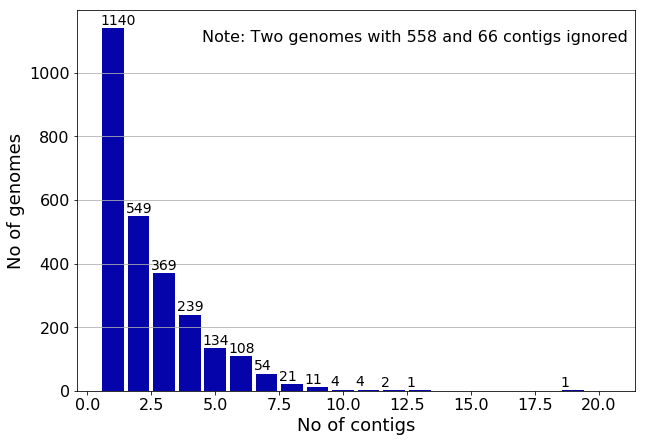

In [18]:
def remove_high_contig_genomes(df_genome_data, contig_cutoff=20):
    '''
    Removes genomes with more than 20 contigs
    '''
    
    df_genome_data = df_genome_data[df_genome_data.Contigs < contig_cutoff]
    
    return df_genome_data


def plot_contig_dist(df_genome_data, fig_path):
    '''
    Plots distribution of contigs per genome 
    '''
    
    d = df_genome_data.Contigs.tolist()

    plt.figure(figsize=(10,7))
    arr = plt.hist(x=d, bins=20, range = (0.5,20.5), color='#0504aa',
                                alpha=1, rwidth=0.85)
    plt.grid(axis='y', alpha=1)
    plt.xlabel('No of contigs',fontsize=18)
    plt.ylabel('No of genomes', fontsize=18)
    plt.text(4.5, 1100, 'Note: Two genomes with 558 and 66 contigs ignored',  fontsize=16)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    for i in range(20):
        if arr[0][i] != 0:
            plt.text(arr[1][i],arr[0][i]+12,str(int(arr[0][i])), fontsize= 14)
            
    plt.savefig(fig_path, pad_inches = 0.1, bbox_inches = 'tight')
    plt.show()
    
    return None

df_genome_data = remove_high_contig_genomes(df_genome_data, 20)
fig_path = '../figures/raw/contig_dist_curation.png'
plot_contig_dist(df_genome_data, fig_path)

### 2. Genomes with atypical (high/low) genome size

In [27]:
def update_genus_cat(df_genome_data, genus_color_palette):
    '''
    Updates dataframe with genera with top 15 genus categories
    '''
    for df_idx in df_genome_data.index:
        genome_name = df_genome_data.loc[df_idx, 'Genome Name']
        genus_name = genome_name.split(' ')[0]

        df_genome_data.loc[df_idx, 'Genus'] = genus_name
        if genus_name in genus_color_palette.keys():
            df_genome_data.loc[df_idx, 'Genus_cat'] = genus_name
        else:
            df_genome_data.loc[df_idx, 'Genus_cat'] = 'Other'
    
    return df_genome_data
    

def get_scatter_data_gc_len(df_genome_data):
    '''
    Returns dataframe for scatter plot of genome length vs gc content as per the genus
    '''
    scat_data = df_genome_data[['Genome Length', 'GC Content']].astype(float)
    
    scat_data['Genome Length'] =  round(scat_data['Genome Length']/1000000,1)
    # Genome length in MBs
    
    scat_data['GC Content'] = round(scat_data['GC Content'],1)
    # GC content rounded off to first decimal
    
    scat_data['genus_cat'] = df_genome_data.Genus_cat
    
    scat_data_cnts = scat_data.groupby(['Genome Length', 'GC Content','genus_cat']).size().reset_index(name='counts')
    
    return scat_data_cnts


def plot_scatter(scat_data_cnts, genus_color_palette, fig_path):
    '''
    Plots sctter distribution of genome length vs gc content as per the genus to evaluate outliers
    '''
    cnt_colors = scat_data_cnts.genus_cat.map(genus_color_palette)
    
    # Create Fig and gridspec
    fig = plt.figure(figsize=(16, 10), dpi= 80)
    grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
    
    # Define the axes
    ax_main = fig.add_subplot(grid[:-1, :-1])
    ax_right = fig.add_subplot(grid[:-1, -1], yticklabels=[])
    ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[])
    
    # Scatterplot on main ax
    ax_main.scatter('Genome Length', 'GC Content', data=scat_data_cnts, s=scat_data_cnts.counts*40, 
                    c=cnt_colors, alpha = 0.55, edgecolors='gray', linewidths=.5)

    # histogram on the right
    ax_bottom.hist(scat_data_cnts['Genome Length'], 40, histtype='stepfilled', orientation='vertical', color='deeppink')
    ax_bottom.invert_yaxis()

    # histogram in the bottom
    ax_right.hist(scat_data_cnts['GC Content'], 20, histtype='stepfilled', orientation='horizontal', 
                  color='deeppink')

    # Decorations
    # ax_main.set(title='No. of clusters vs GC Content', 
    #             xlabel='GC Content', ylabel='No of clusters per genome')
    ax_main.set(title='GC Content vs Genome Length', 
                xlabel='Genome Length (Mb)', ylabel='GC Content(%)')
    ax_main.title.set_fontsize(20)

    ax_bottom.set(ylabel='No of genomes')
    ax_right.set(xlabel='No of genomes')

    for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
        item.set_fontsize(14)

    for item in ([ax_right.xaxis.label, ax_right.yaxis.label] + ax_right.get_xticklabels() + ax_right.get_yticklabels()):
        item.set_fontsize(14)

    for item in ([ax_bottom.xaxis.label, ax_bottom.yaxis.label] + ax_bottom.get_xticklabels() + ax_bottom.get_yticklabels()):
        item.set_fontsize(14)
    plt.savefig(fig_path, pad_inches = 0.1, bbox_inches = 'tight')
    plt.show()
    
    return None
    
def remove_genomes_of_atypical_len(df_genome_data):
    '''
    Removes genomes with shorter lengths 
    '''
    filtered_idx = []
    for df_idx in df_genome_data.index:
        if df_genome_data.loc[df_idx, 'Genus_cat'] not in ['Other']:
            if df_genome_data.loc[df_idx, 'Genome Length'] < int(2000000):
                print(df_idx)
            else:
                filtered_idx.append(df_idx)
        else:
            if df_genome_data.loc[df_idx, 'Genome Length'] > int(8000000):
                print(df_idx)
            else:
                filtered_idx.append(df_idx)        

    df_genome_data = df_genome_data.loc[filtered_idx, :]
    
    return df_genome_data
    
df_genome_data = update_genus_cat(df_genome_data, genus_color_palette)
scat_data_cnts = get_scatter_data_gc_len(df_genome_data)
fig_path = '../figures/raw/scat_plot_curation.png'
plot_scatter(scat_data_cnts, genus_color_palette, fig_path)
df_genome_data = remove_genomes_of_atypical_len(df_genome_data)

1086030.5
138074.5
28141.658
562.7382
562.7622
562.7692
562.7736
568817.3


### 3. N50 genome quality

In [32]:
def get_N50_data(df_genome_data, data_dir = '../data/patric_entero/genomes/', 
                 filtered_genomes = '../data/patric_entero/filtered/'):
    '''
    Calculates N50 score for all genomes 
    '''
    
    for pat in df_genome_data.index:
        fasta_path = os.path.join(data_dir, pat, pat + '.fna')
        seqlength=[]
        if not os.path.isfile(fasta_path):
            fasta_path = os.path.join(filtered_genomes, pat, pat + '.fna')
            # If already removed from input data set to filtered genomes

        for record in SeqIO.parse(fasta_path, 'fasta'): 
            bp=len(record.seq)
            seqlength.append(bp)

        total_len=sum(seqlength)
        seqlength=sorted(seqlength, reverse=True)

        df_genome_data.loc[pat, 'max_seq_len'] = seqlength[0]

        #creat a list of unique lengths 
        unique=[]
        for i in seqlength: 
            if not i in unique: 
                unique.append(i)

        sumlen=0
        for j in unique: 
            numbase=seqlength.count(j)*j
            sumlen=sumlen+numbase
            if sumlen>total_len/2: 
                df_genome_data.loc[pat, 'N50_score'] = j
                break
        
    for pat in df_genome_data.index:
        df_genome_data.loc[pat, 'N50_by_total'] = df_genome_data.loc[pat, 'N50_score'] / df_genome_data.loc[pat, 'Genome Length']
        df_genome_data.loc[pat, 'max_by_total'] = df_genome_data.loc[pat, 'max_seq_len'] / df_genome_data.loc[pat, 'Genome Length']
        
    return df_genome_data


def plot_n50_data(df_genome_data,fig_path):
    '''
    Plots N50 distribution
    '''
    
    df_genome_data_sorted = df_genome_data.sort_values(by='Genome Length')
    ax = df_genome_data_sorted.plot.line(y=['N50_by_total', 'max_by_total'], figsize=(8,4))

    
def remove_low_N50(df_genome_data, cutoff=0.5):
    '''
    Removes genomes with low N50 by total ration
    '''
    
    filtered_idx = []
    for df_idx in df_genome_data.index:
        if df_genome_data.loc[df_idx, 'N50_by_total'] < cutoff:
            print(df_idx)
        else:
            filtered_idx.append(df_idx)        

    df_genome_data = df_genome_data.loc[filtered_idx, :]
    
    return df_genome_data
    
df_genome_data = get_N50_data(df_genome_data)
fig_path = '../figures/raw/N50_stats_curation.png'
plot_n50_data(df_genome_data, fig_path)
df_genome_data = remove_low_N50(df_genome_data, 0.5)

138072.44
548.405


### Genomes with multiple datasets

In [35]:
def get_redundant_genomes(df_genome_data):
    '''
    Returns a separate dataframe with strains having multiple genome dataset
    '''
    
    genome_name_dict = dict()
    genome_len_dict = dict()
    multidata_genomes_list = list()

    for df_idx in df_genome_data.index:
        genome_name = df_genome_data.loc[df_idx, 'Genome Name']
        pat_id = df_idx
        genome_len = df_genome_data.loc[df_idx, 'Genome Length']

        if genome_name not in genome_name_dict.keys():
            genome_name_dict[genome_name] = [pat_id]
            genome_len_dict[genome_name] = [genome_len]
        else:
            genome_name_dict[genome_name].append(pat_id)
            genome_len_dict[genome_name].append(genome_len)

            if genome_name not in multidata_genomes_list:
                multidata_genomes_list.append(genome_name)

    print(len(multidata_genomes_list), 'Genomes with more than one datasets... \n')
    for genome_name in multidata_genomes_list:
        print(genome_name, '\n PATRIC IDs:', genome_name_dict[genome_name], 
              '\n Genome lengths', genome_len_dict[genome_name], '\n')

    # Pick up one dataset? 
    df_multi_data = pd.DataFrame(index=multidata_genomes_list, columns=['Selected Patric', 'Selcted Assembly Accession', 
                                                                        'All Patric IDs'])
    for org in multidata_genomes_list:
        df_multi_data.loc[org, 'All Patric IDs'] = genome_name_dict[org]
    
    return df_multi_data


df_multi_data = get_redundant_genomes(df_genome_data)

37 Genomes with more than one datasets... 

Yersinia pestis A1122 
 PATRIC IDs: ['1035377.4', '1035377.9'] 
 Genome lengths [4658411, 4674565] 

synthetic Escherichia coli C321.deltaA 
 PATRIC IDs: ['1385755.5', '1385755.6'] 
 Genome lengths [4650162, 4650152] 

Klebsiella quasipneumoniae strain ATCC 700603 
 PATRIC IDs: ['1463165.4', '1463165.70'] 
 Genome lengths [5586672, 5513032] 

Salmonella enterica subsp. enterica serovar Enteritidis 
 PATRIC IDs: ['149539.317', '149539.318', '149539.319', '149539.320', '149539.321', '149539.324', '149539.325', '149539.326', '149539.327'] 
 Genome lengths [4710936, 4667283, 4671261, 4709890, 4702741, 4678377, 4678571, 4678914, 4677619] 

Escherichia coli O157:H7 str. EDL933 
 PATRIC IDs: ['155864.210', '155864.42', '155864.8'] 
 Genome lengths [4709911, 5639399, 5620522] 

Shigella flexneri 4c 
 PATRIC IDs: ['1617964.7', '1617964.8'] 
 Genome lengths [4980844, 4767656] 

Yersinia pestis CO92 
 PATRIC IDs: ['214092.181', '214092.21'] 
 Genome len

In [36]:
### Save final dataset for further analysis as df_entero
df_genome_data.to_csv('../tables/patric_entero/df_entero.csv')
df_genome_data.to_pickle('../pickles/df_entero.p')
df_multi_data.to_csv('../tables/patric_entero/select_multiple_genomes.csv')